**Reinforcement Learning**

*This notebook uses Upper Confidence Bound to optimize ad selection process for the company*

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['Ads_Optimisation.csv']


In [3]:
ads_df = pd.read_csv("../input/Ads_Optimisation.csv")
ads_df.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


**Always** *Check for missing values*

In [4]:
ads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
Ad 1     10000 non-null int64
Ad 2     10000 non-null int64
Ad 3     10000 non-null int64
Ad 4     10000 non-null int64
Ad 5     10000 non-null int64
Ad 6     10000 non-null int64
Ad 7     10000 non-null int64
Ad 8     10000 non-null int64
Ad 9     10000 non-null int64
Ad 10    10000 non-null int64
dtypes: int64(10)
memory usage: 781.3 KB


*No missing data fortunately*

**Let us now visualize manually which ads performs the best, i.e., gets most clicks**

Text(0.5, 1.0, 'Ads_Performance')

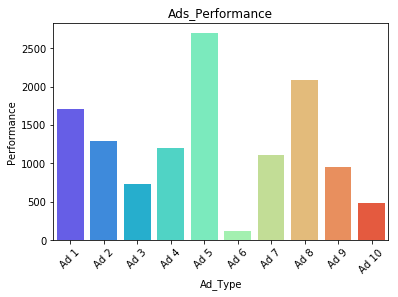

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
ads = ads_df.columns
ad_reward = [ads_df.values[:,i].sum() for i in range(len(ads))]
plt.xticks(rotation = 45)
sns.barplot(ads, ad_reward, palette='rainbow')
plt.ylabel('Performance')
plt.xlabel('Ad_Type')
plt.title('Ads_Performance')

*The inference we get from the above plot is that the Ad_5 is the best performing ad*

**Let us first check what result a random selection process will yeild so that we can compare our results**

In [6]:
import random
d = len(ads)
rounds = ads_df.values.shape[0]
ad_selected = []
total_reward = 0

for n in range(rounds):
    ad = random.randint(1,10)
    reward = ads_df.values[n,ad-1]
    total_reward += reward
    ad_selected.append(ad-1)

print('Total Reward on Random Selection of Ads: {}'.format(total_reward)) 

Total Reward on Random Selection of Ads: 1306


**Lets visualize the random selection**

Text(0.5, 0, 'Ad_Type')

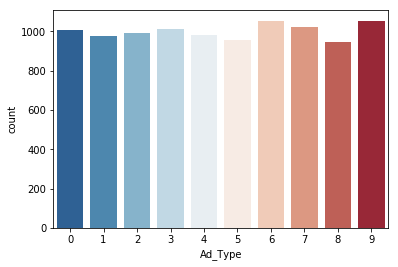

In [7]:
sns.countplot(ad_selected, palette='RdBu_r')
plt.xlabel('Ad_Type')


*As we can see, the ads are Uniformly selected, therefore, no learning.*

*Let us try to guess why Ad_5 might perform better. Since there is no additional data given, we can make our own guesses.*        
*1. Ad_5 appeals best to the age group the company makes product for 2. More colors, more creativity 3. Advertizement in better platform(assuming different platform for different ads) and other reasons that you can think of.*

**Let us now see how using Upper Confidence Bound can optimize our result**

In [8]:
num_ad_i_selcted =[0]*d   # where each column represents each ad
total_reward_i = [0]*d    # columns will represent the clicks each ad got
ad_selected = []
total_reward = 0
for n in range(rounds):
    max_ucb = 0
    ad= 0
    for i in range(0,d):
        '''this if-else condition makes sure that for the first 10 rounds we have each ad selected once
        so that we have some values to start with'''
        if num_ad_i_selcted[i]>0:
            average_reward = total_reward_i[i]/num_ad_i_selcted[i] # Calculating average reward
            delta_i = np.sqrt((3/2)*np.log(n+1)/num_ad_i_selcted[i])
            ucb = average_reward + delta_i # Defining the upper bound
        else:
            ucb = 1e400
        if ucb>max_ucb:
            max_ucb = ucb
            ad = i
    ad_selected.append(ad)
    num_ad_i_selcted[ad] += 1
    reward = ads_df.values[n,ad]
    total_reward_i[ad] += reward
    total_reward += reward

print('Total Clicks on Ads: {}'.format(total_reward))

Total Clicks on Ads: 2178


*So the UCB algorithm seems to perform much better than then the one with randomly selected ads*

**Let's visualize some data from the above algorithm**

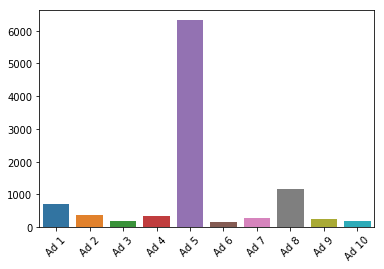

In [9]:
plt.xticks(rotation = 45)
sns.barplot(ads, num_ad_i_selcted)

*The graph shows that according to the algorithm, Ad_5 should be selected for best result*

*Since we already knew that the Ad_5 is the best performing one, the above graph is the proof that the algorithm is trying to optimmize the result by learning on its own*


**Let us use Thompson Sampling to see if we can further optimize our results**

In [11]:
d = 10
rounds = 10000
num_reward_0 =[0]*d # where each column represents each ad
num_reward_1 = [0]*d
ad_selected = []
total_reward = 0
for n in range(rounds):
    max_random = 0
    ad= 0
    for i in range(0,d):
        random_dist = random.betavariate(num_reward_1[i]+1,num_reward_0[i]+1 )
        if random_dist>max_random:
            max_random = random_dist
            ad = i
    ad_selected.append(ad)
    reward = ads_df.values[n,ad]
    if reward == 1:
        num_reward_1[ad] += 1
    else:
        num_reward_0[ad] += 0
    total_reward += reward

print(total_reward)

2506


*Since the Thompson Sampling is based on random distribution(betavariate), the values will change every time we run the code*

*In almost all cases Thompson Sampling outperforms UCB algorithm*

**Lets visualize the outcome of the algorithm**

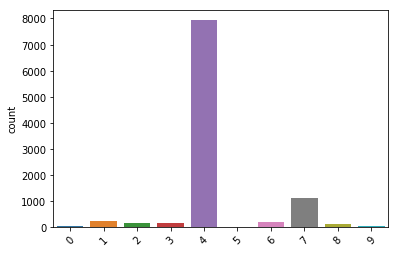

In [12]:
plt.xticks(rotation = 45)
sns.countplot(ad_selected)

*In the above graph, 0 means Ad_1, and so on*

*The graph shows that it took less time for the Thompson Sampling algorithm to realize that the Ad_5 is the best performing  ad*


**These are some examples of how Reinforcement Learning learns from its enviornment and try to produce optimized results** 